In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,  Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import quandl
from fredapi import Fred

pd.set_option("display.max_rows",200)
sns.set(rc={'figure.figsize':(16,10)})
fred_key = "df4910b2cad947d95cf6ab16ba11d74d"
fred = Fred(api_key = fred_key)
quandl.ApiConfig.api_key = 'Qq5R29Xiqp2yUbb9dzNq'


In [ ]:
def plot(prediction,target,grey=None,start=None,end=None):
    
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # else:
    #     ylim = (df.min(),df.max())
    

    if not isinstance(prediction,pd.DataFrame):
        Results=pd.DataFrame(prediction,index=target.index)
        Results.plot(ax=ax,legend=True)
        ylim = (Results.min().min(),Results.max().max())
    else:
        prediction.plot(ax=ax,legend=True)
        ylim = (0,1)
    ax.fill_between(target.index, 0, ylim[1]+1e-2, target,facecolor='k', alpha=0.1)
    if not isinstance(prediction,pd.DataFrame):
        legend_list=["Prediction", "NBER recession indicator"]
    else:
        legend_list=["Prediction",'lower','upper', "NBER recession indicator"]
    # if '2022-02-24' in target.index:
    #     legend_list+=['Russian invasion of Ukraine']
    #     ax.axvline(x='2022-02-24', color='r')
    ax.legend(legend_list)
        
    return fig,ax

In [ ]:
fixed_data=0

In [ ]:
MacroCode=pd.read_csv(r'Data\Macro Variables.csv')
MacroCode.replace({'Average HOUST':'HOUST','S&P 500':'SP500'},inplace=True)

errors=[]
indicators={}
freq={}
for code in MacroCode['Variable']:
    if not ('S&P' in code):
        try:
            col=fred.get_series(code).to_frame(code).squeeze()
            if code == 'CPFF':
                indicators[code]=(col) #.resample('MS').last()
            elif code == "ICSA":
                indicators[code]=(col) #.resample('MS').sum()
            elif code == "SP500":
                indicators[code]=(col) #.resample('MS').first()
            else:
                indicators[code]=(col) # .resample('M').interpolate()
        except ValueError:
            errors.append(code)
indicators['S&P: indust']=(yf.download('^SP500-20')['Close'].to_frame('S&P: indust').squeeze()) # .resample("MS").last()
indicators['S&P div yield']=(quandl.get("MULTPL/SP500_DIV_YIELD_MONTH").squeeze().to_frame('S&P div yield').squeeze()) # .resample("MS").last()
indicators['S&P PE ratio']=(quandl.get("MULTPL/SP500_PE_RATIO_MONTH").squeeze().to_frame('S&P PE ratio').squeeze()) # .resample("MS").first()


[*********************100%***********************]  1 of 1 completed


In [ ]:
for key in indicators:
    print(key,pd.infer_freq(indicators[key].index))

RPI MS
W875RX1 MS
DPCERA3M086SBEA MS
CMRMTSPL MS
RSXFS MS
INDPRO MS
IPFPNSS MS
IPFINAL MS
IPCONGD MS
IPDCONGD MS
IPNCONGD MS
IPBUSEQ MS
IPMAT MS
IPDMAT MS
IPNMAT MS
IPMANSICS MS
IPB51222S MS
IPFUELS MS
CUMFNS MS
CLF16OV MS
CE16OV MS
UNRATE MS
UEMPMEAN MS
UEMPLT5 MS
UEMP5TO14 MS
UEMP15OV MS
UEMP15T26 MS
UEMP27OV MS
ICSA W-SAT
PAYEMS MS
USGOOD MS
CES1021000001 MS
USCONS MS
MANEMP MS
DMANEMP MS
NDMANEMP MS
SRVPRD MS
USTPU MS
USWTRADE MS
USTRADE MS
USFIRE MS
USGOVT MS
CES0600000007 MS
AWOTMAN MS
AWHMAN MS
HOUST MS
HOUSTNE MS
HOUSTMW MS
HOUSTS MS
HOUSTW MS
PERMIT MS
PERMITNE MS
PERMITMW MS
PERMITS MS
PERMITW MS
ACOGNO MS
DGORDER MS
NEWORDER MS
AMDMUO MS
BUSINV MS
ISRATIO MS
M1SL MS
M2SL MS
M2REAL MS
AMBSL MS
TOTRESNS MS
NONBORRES MS
BUSLOANS MS
REALLN MS
NONREVSL MS
TOTALSL MS
SP500 B
FEDFUNDS MS
TB3MS MS
TB6MS MS
GS1 MS
GS5 MS
GS10 MS
AAA MS
BAA MS
CPFF B
TB3SMFFM MS
TB6SMFFM MS
T1YFFM MS
T5YFFM MS
T10YFFM MS
AAAFFM MS
BAAFFM MS
TWEXMMTH MS
EXSZUS MS
EXJPUS MS
EXUSUK MS
EXCAUS MS
WPSFD4920

In [ ]:
indicators['S&P: indust'].tail(10)

Date
2023-05-08    838.820007
2023-05-09    840.280029
2023-05-10    837.559998
2023-05-11    832.150024
2023-05-12    832.239990
2023-05-15    836.460022
2023-05-16    825.059998
2023-05-17    839.090027
2023-05-18    844.690002
2023-05-19    842.419983
Name: S&P: indust, dtype: float64

In [ ]:
if len(errors)>0:
    raise Exception("Erorrs found")
data=pd.concat(indicators,axis=1).copy().fillna(method='ffill') #.loc["1971":].dropna(how='all').fillna(method='ffill')
# data.to_csv('Data/HistoricalVariables.csv')
print(data.shape)
data.isna().sum().sort_values()/data.shape[0]

(13703, 124)


S&P PE ratio       0.000000
S&P div yield      0.000073
AMBSL              0.082318
BAA                0.084069
AAA                0.084069
INDPRO             0.084069
IPMANSICS          0.084069
TB3MS              0.110341
USCONS             0.119098
MANEMP             0.119098
DMANEMP            0.119098
NDMANEMP           0.119098
SRVPRD             0.119098
USTRADE            0.119098
USWTRADE           0.119098
USGOOD             0.119098
USFIRE             0.119098
USGOVT             0.119098
CES3000000008      0.119098
USTPU              0.119098
PAYEMS             0.119098
AWHMAN             0.119098
IPMAT              0.119098
IPCONGD            0.119098
IPFPNSS            0.119098
IPFINAL            0.119098
DTCTHFNM           0.126104
DTCOLNVHFNM        0.126104
TOTALSL            0.126104
NONREVSL           0.126104
WTISPLC            0.131358
CES0600000007      0.133110
CES2000000008      0.133110
IPDCONGD           0.133110
CES0600000008      0.133110
CPITRNSL           0

In [ ]:
def deltaX(data):
    return data.diff()

def delta2X(data):
    return data-2*data.shift(1)+data.shift(2)

def logdata(data):
    return np.log(data)

def difflog(data):
    return np.log(data).diff()

def difflog2(data):
    return np.log(data)-2*np.log(data.shift(1))+np.log(data.shift(2))

def diffpercent(data):
    return (data/data.shift() - 1) - (data.shift()/data.shift(2) - 1)



transformation={1:(lambda x: x),
                2:deltaX,
                3:delta2X,
                4:logdata,
                5:difflog,
                6:difflog2,
                7:diffpercent,
                }

df_transformed=pd.DataFrame()

for column in data.columns:
    type=MacroCode[MacroCode['Variable'] == column]['Transformation'].iloc[0]
    df_transformed[column]=transformation[type](data[column])
    df_transformed=df_transformed.copy()

In [ ]:
df_transformed.loc['1971':]

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES2000000008,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.014213,0.011976,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.00,0.031962
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.014213,-0.011976,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.00,0.000000
1971-01-09,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.00,0.000000
1971-01-16,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.00,0.000000
1971-01-23,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,-0.013723,0.00,0.000000
2023-05-17,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.016862,0.00,0.000000
2023-05-18,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.006652,0.00,0.000000
2023-05-19,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,-0.002691,0.00,0.000000


In [ ]:
# df=yf.download("GE")
# df.head()
n_lookback=30
n_forecast=1

# df=pd.read_csv('Data/Transformed HistoricalVariables.csv',index_col=0,parse_dates=True)
df=df_transformed.loc['1971':].copy()
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES2000000008,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.014213,0.011976,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.0,0.031962
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.014213,-0.011976,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.0,0.000000
1971-01-09,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000
1971-01-16,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000
1971-01-23,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000


In [ ]:

recessions =  DataReader('USRECDM', 'fred', start='1800')
df[f'in a recession']=recessions
df['target'] = recessions.shift(-250)

df.fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1971':] #.resample('MS').last()
print(df.shape)
df.head()

(11109, 126)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,in a recession,target
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.0,0.031962,0.0,0.0
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.0,0.000000,0.0,0.0
1971-01-09,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0
1971-01-16,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0
1971-01-23,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0


<Axes: >

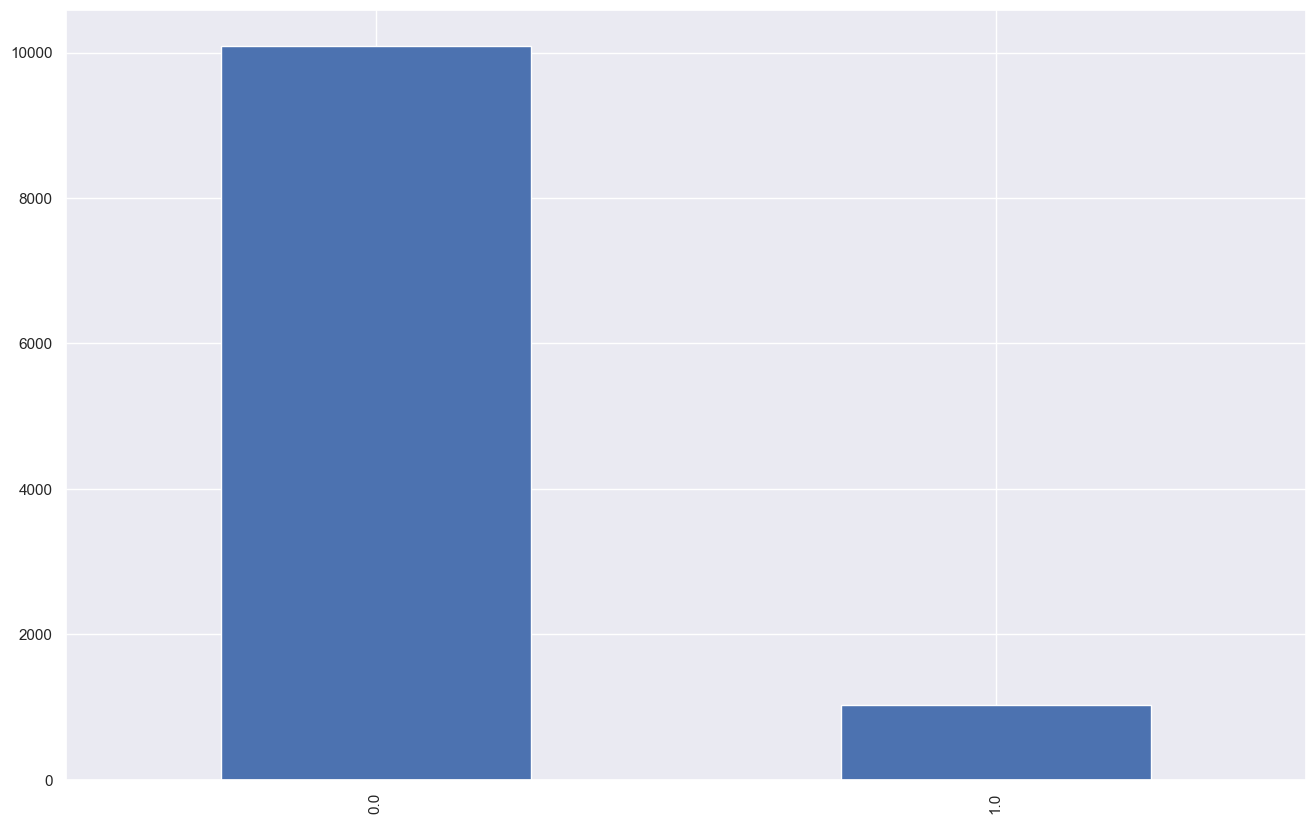

In [ ]:
df.target.value_counts().plot.bar()

In [ ]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)

In [ ]:
df_for_training=df[:"2004"]
df_for_testing=df["2004":]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_testing shape: ',df_for_testing.shape)

# Scalling

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))

print()
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
trainX.shape,trainY.shape

df_for_training shape:  (5292, 126)
df_for_testing shape:  (6135, 126)



((5262, 30, 125), (5262, 1))

# with recessions 

In [ ]:
def CustomLoss(labels, pred,w=0.2): 
    logits=tf.math.log(pred/(1-pred))
    return tf.nn.weighted_cross_entropy_with_logits(labels, logits, w)

In [ ]:
from tensorflow.keras.layers import LSTM,  Dense, Dropout, Conv1D, MaxPool1D,Flatten,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

PT_path='Model/CNN2-LSTM-test'
f1 = EarlyStopping(monitor='recall', mode='max', verbose=1, patience=30)
f2 = ModelCheckpoint(filepath=PT_path, monitor='recall', mode='max', verbose=0, save_best_only=True)



In [ ]:

model = Sequential()
model.add(Conv1D(filters=32,kernel_size=(5,),activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]),))
model.add(Conv1D(filters=32,kernel_size=(5,),activation='relu'))
# model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu'))
model.add(MaxPool1D(1))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(100, return_sequences=False))
model.add(Dense((n_forecast)
            ,activation='sigmoid'
            ))
model.summary()
# fit the model
model.compile(optimizer='adam',
              metrics=['Recall','Precision',"AUC"],
              loss=CustomLoss
            # loss='BinaryCrossentropy'
              )
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=320, 
                    validation_split=0.1, 
                    verbose=1,  
                    callbacks=[
                                #  f1,
                                f2
                               ]
                  )


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 26, 32)            20032     
                                                                 
 conv1d_17 (Conv1D)          (None, 22, 32)            5152      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 22, 32)           0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 22, 32)            0         
                                                                 
 flatten_8 (Flatten)         (None, 704)               0         
                                                                 
 repeat_vector_8 (RepeatVect  (None, 1, 704)           0         
 or)                                                  

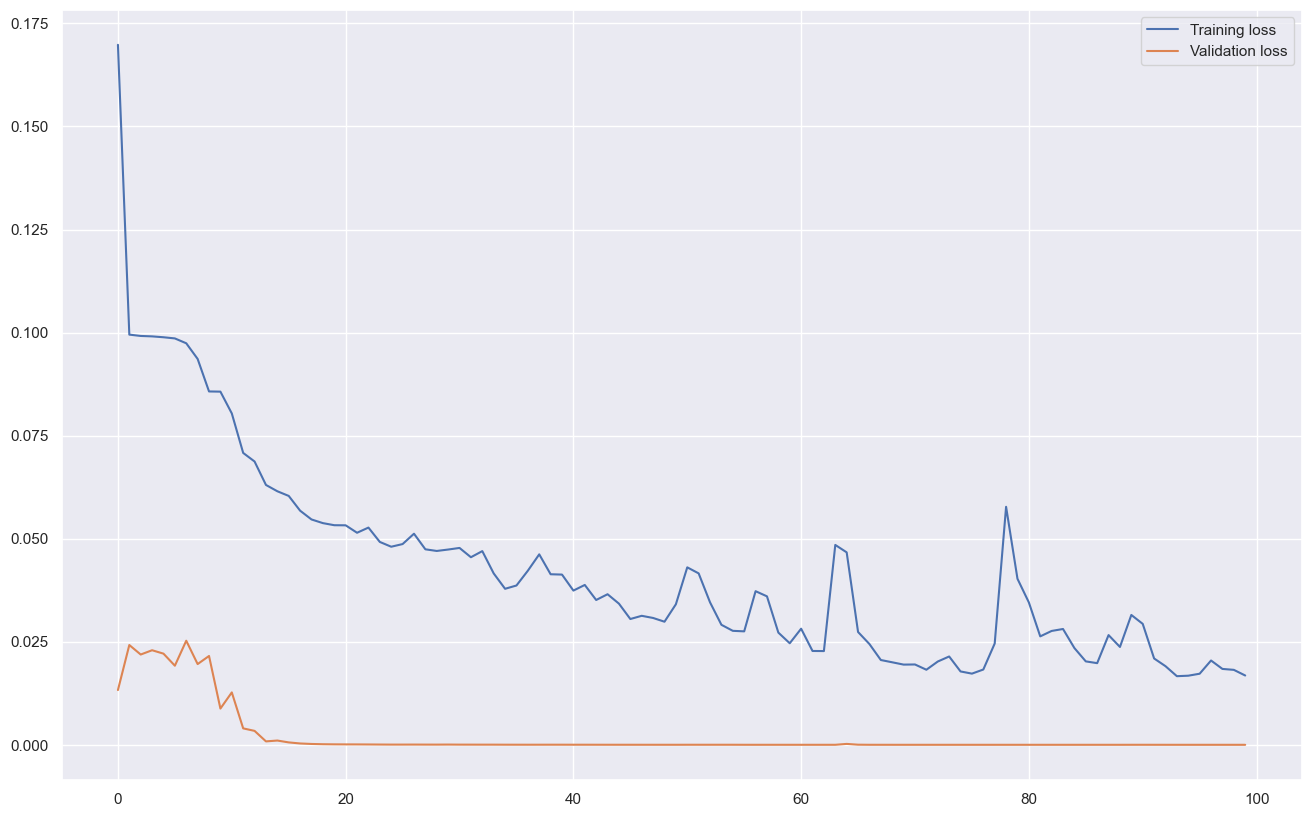

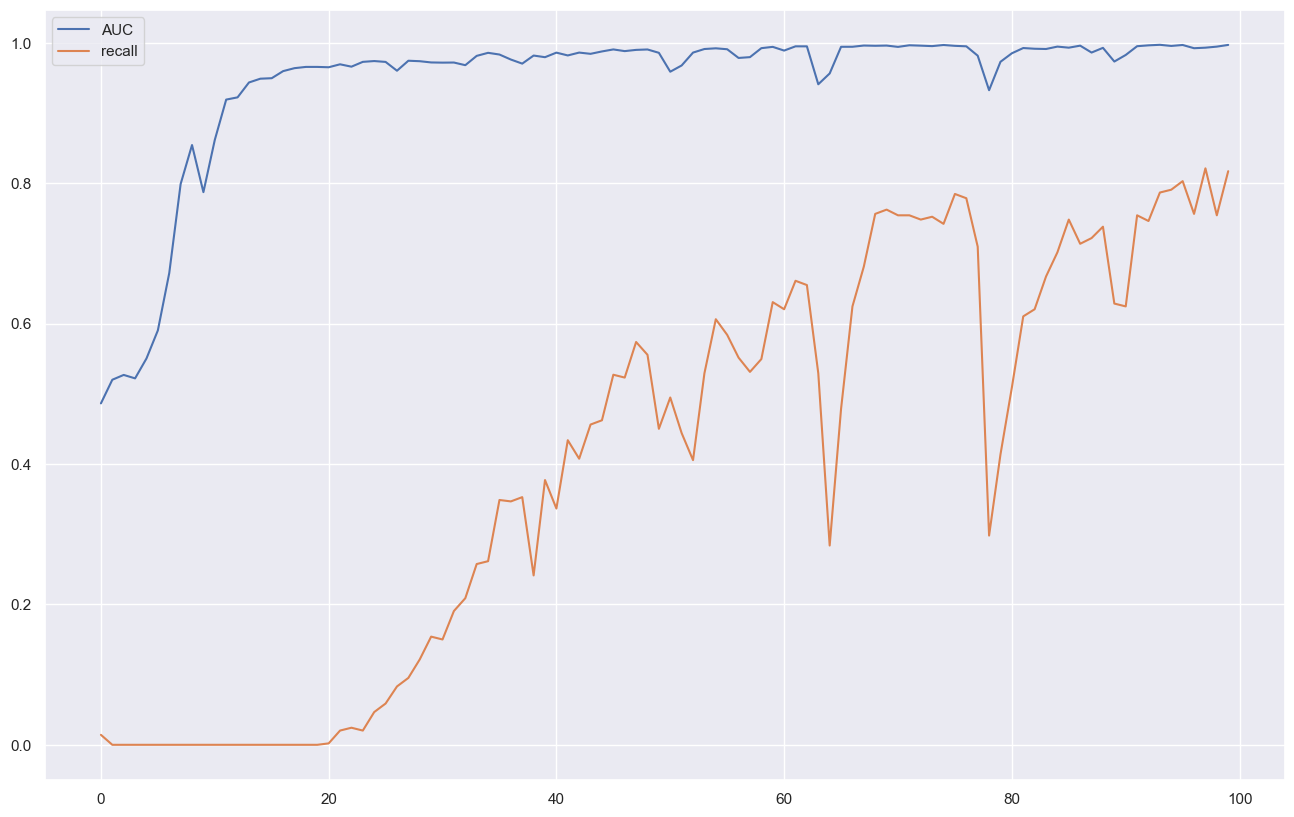

In [ ]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show();
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['recall'], label='recall')
plt.legend()

In [ ]:
PT_path

'Model/CNN2-LSTM-test'

In [ ]:
# model.load_weights(PT_path)

ValueError: Received incompatible tensor with shape (128,) when attempting to restore variable with shape (32,) and name layer_with_weights-0/bias/.ATTRIBUTES/VARIABLE_VALUE.

In [ ]:
prediction_train=model.predict(trainX).mean(axis=1)
trainResults= pd.DataFrame()


165/165 [==============================] - 2s 7ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

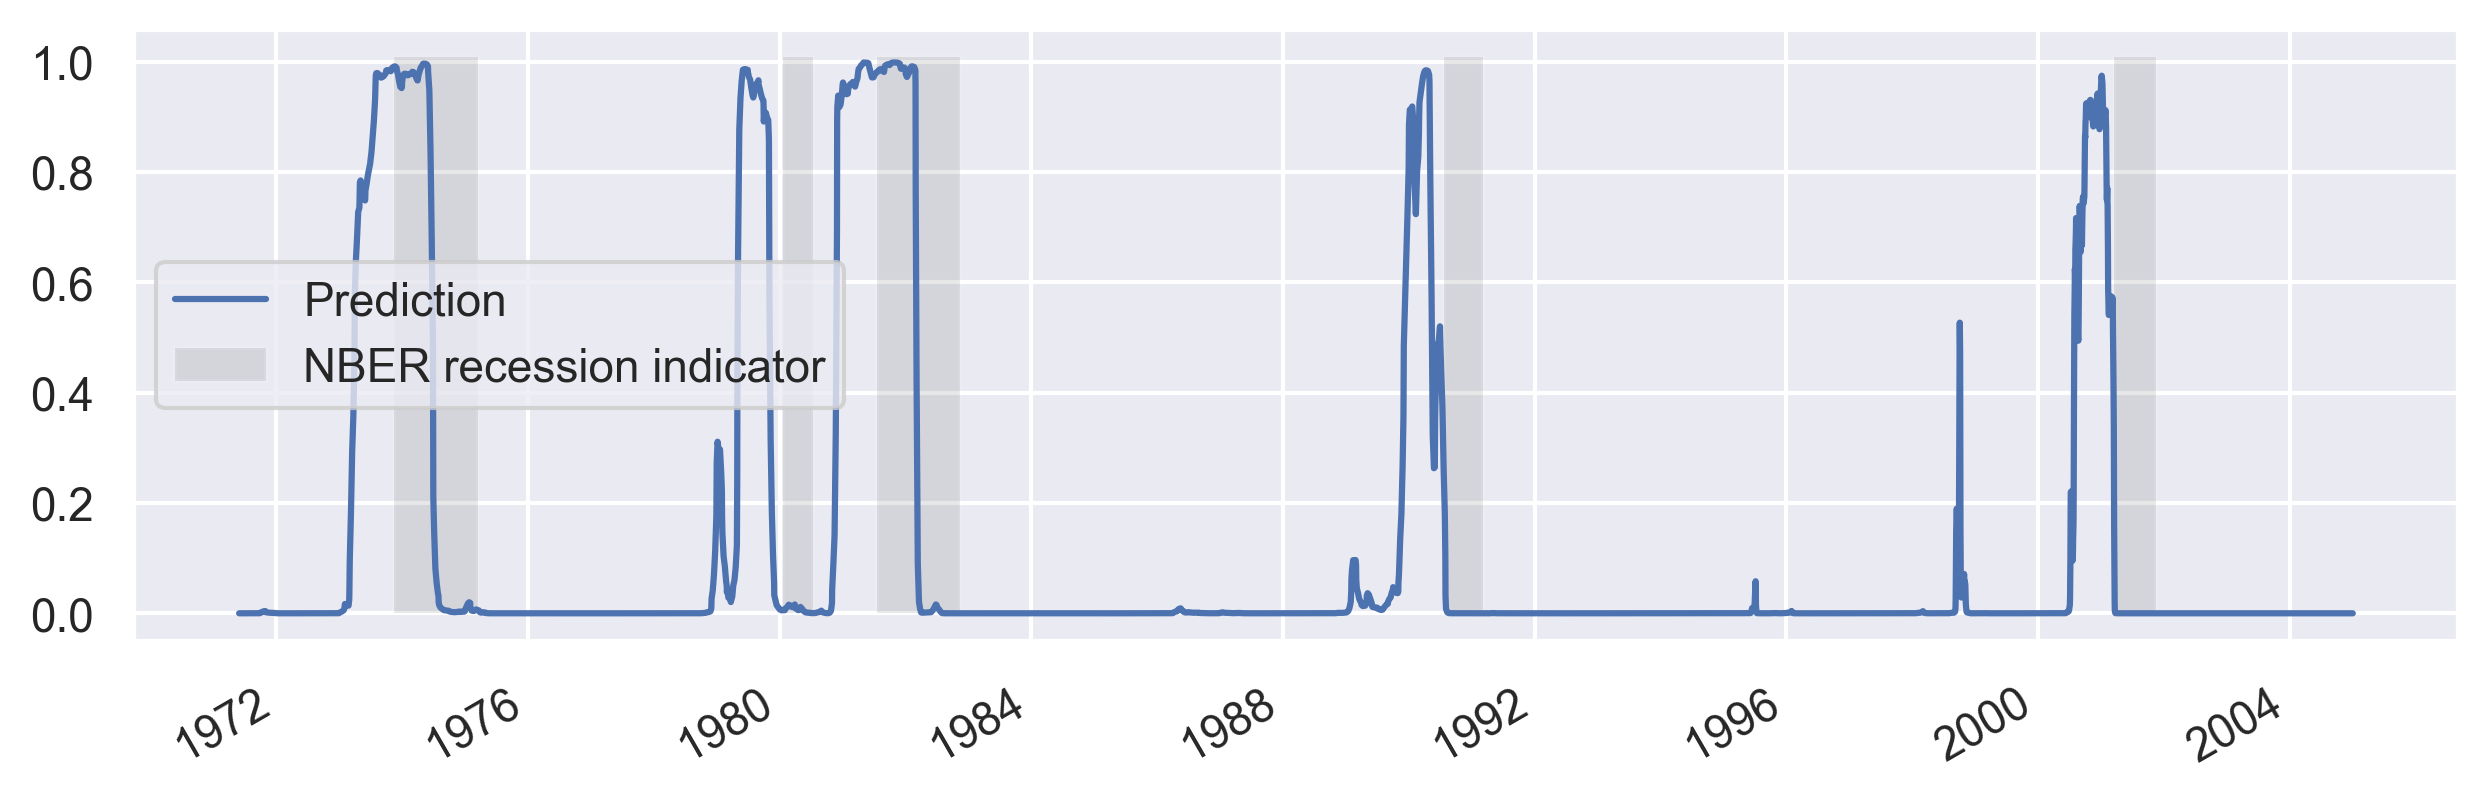

In [ ]:
min_length = min(len(df_for_training), len(prediction_train))
trainResults['Actual']=df_for_training.iloc[-min_length:,-2]
trainResults['Pred']=prediction_train[-min_length:]
plot(trainResults['Pred'],trainResults['Actual'])

In [ ]:
prediction=model.predict(testX)
min_length = min(len(df_for_testing), len(prediction))
testResults = pd.DataFrame()


191/191 [==============================] - 1s 7ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

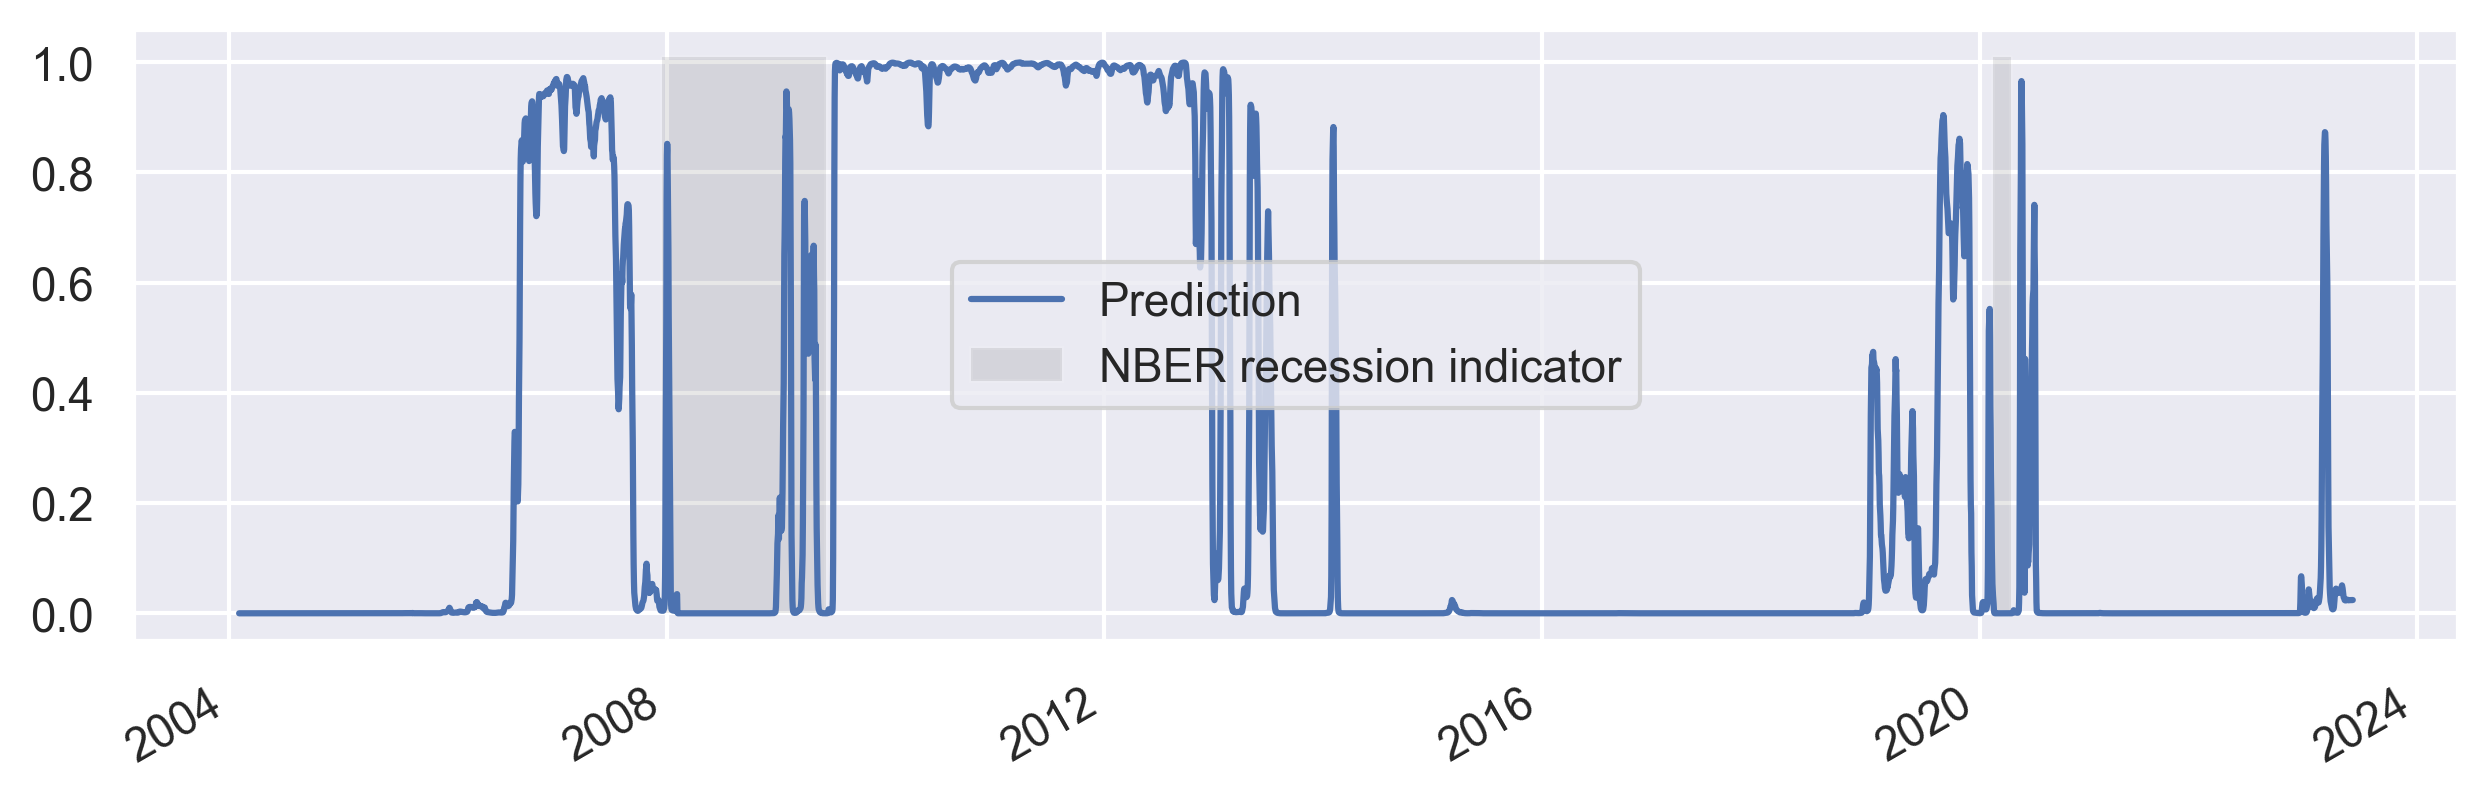

In [ ]:
testResults['Actual']=df_for_testing.iloc[-min_length:, -2]
testResults["Pred"]=prediction[-min_length:]
plot((testResults['Pred']).rolling(1).mean(),testResults["Actual"])

In [ ]:

pred=prediction
origin=df_for_testing


min_length = min(len(origin), len(prediction))
pred=pred[-min_length:]
origin=origin.iloc[-min_length:, -2]

aligned = pd.DataFrame(columns=[f'pred{i}' for i in range(n_forecast)], index=pd.date_range(
    start=origin.index[0], freq='D', periods=pred.shape[0]+n_forecast-1))
for i in range(len(prediction)):
    col=i % n_forecast
    try:
        aligned.iloc[i:i+n_forecast,col]=prediction[i]
    except IndexError:
        break
CI=aligned.std(axis=1)* 1.96 / np.sqrt(aligned.shape[1])
mean=aligned.mean(axis=1)
aligned=pd.concat([mean,mean-CI,mean+CI],keys=['m','lc',"uc"],axis=1)
plot(aligned,testResults["Actual"])